Demonstration of insensitivity to $\alpha$ using Aurel's original code.

In [1]:
import new_slda.functionals.SSLDA
slda_aurel = new_slda.functionals.SSLDA.SSLDAFunctional(xi_poly=[0.42], eta_poly=[0.504], alpha_poly=[1.14])
slda_alpha1 = new_slda.functionals.SSLDA.SSLDAFunctional(xi_poly=[0.42], eta_poly=[0.504], alpha_poly=[1.0])
for slda in [slda_aurel, slda_alpha1]:
    print("alpha=%g, beta=%g, gammainv=%g" % (slda.alpha_poly[0], slda.beta_thermo, slda.gammainv_thermo))

ModuleNotFoundError: No module named 'new_slda'

The following is a direct translation of Aurel's published code to python minus the specification of the parameters.

In [2]:
%%file tmp.py
#--------------------------------------------------------------------------------
# Compute energies and <r^2> for N=(1:30) and compare with ab initio
# results of: 
# - Chang and Bertsch, PRA 76, 021603(R) (2007) [arXiv:physics/0703190v1]
# - von Stecher, Greene and Blume, PRL 99, 233201 (2007) [arXiv:0708.2734v2]
# and arXiv:0801.2747v1
#
# 
# SLDA with Bessel-DVR method, Littlejohn and Cargo, J.Chem.Phys. 117, 27 (2002)
# Broyden updates on all sites at once 
# fixed particle numbers for both spin up and down species
# smoothing around Ec and finite temperature
#
# Units: m=hbar=omega=1 since a gas at unitarity in a harmonic trap has
# universal properties as well and m, hbar and omega factor out of the
# problem, see Bulgac, PRA, 040502(R) (2007)
# 
# This is the acutal program used for calculations in the above publication
#
#  
#--------------------------------------------------------------------------------
from __future__ import division # Otherwise 1/2 == 1//2 = 0
import time
from pylab import sqrt, array, asarray, arange, eigh, dot             # Not best practise, but simplifies conversion
import numpy as np

eps = finfo(float).eps

np.set_printoptions(precision=4, linewidth=100)

amix    = 1.0      #  weight in the usual iterative procedure with linear mixing
bmix    = 1.0      #  size of dx step with Broyden 
cmix    = 1.0      #  initial Jacobian

convergence_limit = 1.0e-9
deps    = 1.0e-15  # essentially defines machine precisions 
ddmu    = 1.0e-6
part_c  = 0
ener_c  = 0
nlpr    = 101
nplot   = 101

Nmax    = 100
Niter   = 0*Nmax
Kmax    = sqrt(2*Nmax+3)+3
# Rmax    = Kmax
Rmax    = 9.0

#---------------------------------------------------------------------------------
#  The energy cutoff Ec is made smooth with a Fermi function 
#
#  A small finite temperature is introduced in order to faciltitate convergence 
#  especially in the case of odd or polarized systems. The actual value of
#  T is so small as to be insignificant physically and it ca n be put T=0
#  at the end of calculations
#---------------------------------------------------------------------------------
Ec      = 0.95*(Nmax+1.5)
dEc     = Ec/50
Temp    = 0.025
four_pi = 4*pi

#-------------------------------------------------------------
# here I construct various things needed for the DVR method 
#-------------------------------------------------------------
# determine the zeros of the Bessel functions j0(z) and j1(z)
#-------------------------------------------------------------
Nzeros = 500
nn  = arange(1, Nzeros + 1)
Z0  = pi*nn
Z1  = pi*(nn + 0.5)
for _i in xrange(20):
    Z1 = nn*pi + arctan(Z1)

#-------------------------------------------------------------

iz0 = where( Z0 <= Rmax*Kmax)[0]
iz1 = where( Z1 <= Rmax*Kmax)[0]

#----------------------------------------------------------------------
# Here I construct kinetic energy matrix for l=0 and l=1,
# see Littlejohn and Cargo, J.Chem.Phys. 117, 27 (2002) for Bessel-DVR.
# I am using the l=0 lattice points for even ls and l=1 for odd ones,
# see Nygaard, Bruun, Schneider, Clark and Feder, PRA 69, 053622 (2004) 
# [arXiv:cond-mat/0312258v1]. I have also checked rather extensively 
# on a number of exact solutions.
#----------------------------------------------------------------------
for l0 in [0, 1]:
    if l0 == 0:
        n0 = iz0
        z0 = Z0[n0]       # zeros of spherical Bessel function
        nu0 = 1/2
        [m1,m2]  = meshgrid(n0,n0)
        [zz1, zz2] = meshgrid(z0,z0)
        t0 = (1+2*(nu0**2-1)/z0**2)/3
        t1 = 8*(-1)**(m1-m2)*zz1*zz2/( (zz1**2-zz2**2)**2 + eps )
        t1 = t1-diag(diag(t1))
        T0    = Kmax**2*(diag(t0) + t1)/2*alpha
        zmax0 = z0[-1]
        r0    = z0/Kmax
        r0_2  = r0**2
        mm0 = len(n0)
    elif l0 == 1:
        n1 = iz1
        z1 = Z1[n1]
        nu0 = 3/2
        [m1,m2]  = meshgrid(n1,n1)
        [zz1, zz2] = meshgrid(z1,z1)
        t0 = (1+2*(nu0**2-1)/z1**2)/3
        t1 = 8*(-1)**(m1-m2)*zz1*zz2/( (zz1**2-zz2**2)**2 + eps )
        t1 = t1-diag(diag(t1))
        T1    = Kmax**2*(diag(t0) + t1)/2*alpha
        zmax1 = z1[-1]
        r1    = z1/Kmax
        r1_2  = r1**2
        mm1 = len(n1)

#--------------------------------------------------------------------

#=================================================================
#  convert from one coordinate set f(r_a) to another f(r_b) 
#  calculate weights
#=================================================================
U1_0 = zeros((mm1,mm0))
U0_1 = zeros((mm0,mm1))
C0   = zeros(mm0)         # 1/F0(z0)
C1   = zeros(mm1)         # 1/F1(z1)
for i0 in xrange(mm0):
    a          = cos(z0[i0])/sqrt(z0[i0])
    b          = sin(z1)/sqrt(z1)
    U1_0[:,i0] = 2*sqrt(z0[i0]*z1)/(z1**2-z0[i0]**2)*b/a
    C0[i0]     = sqrt(pi/Kmax)

C0_2 = C0**2

for i1 in xrange(mm1):
    a          = sin(z1[i1])/sqrt(z1[i1])
    b          = -cos(z0)/sqrt(z0)
    U0_1[:,i1] = 2*sqrt(z1[i1]*z0)/(z0**2-z1[i1]**2)*b/a
    C1[i1]     = sqrt(pi/Kmax/(sin(z1[i1]))**2)

C1_2 = C1**2
#-----------------------------------------------------------------------
# clear Nzeros nn Z0 Z1 m1 m2 zz1 zz2 iz0 iz1 t0 t1 nu0 a b 
#-----------------------------------------------------------------------
# this concludes the determination of various quantities needed for DVR
#-----------------------------------------------------------------------

Number_Density = []
En = [1.37]
R2 = [1.37]
Nn = [1]

##################################################################### 
for  N in xrange(2, 31):          # total particle number
    print("Solving N = %i" % (N,))
    tic = time.time()

    N_a     = ceil(N/2)   # number of spin-up particles
    N_b     = floor(N/2)  # number of spin-down particles

    #----------------------------------------------------------------------
    # Start iterations
    #
    # The intial guesses for densities, fields and chemical potentials
    # are rather crude. Note that the particle numbers obtained from these 
    # initial guess for number densities are rather far from the desired
    # values (almost by a factor of two sometimes), but that has little
    # effect on the convergence 
    #
    #
    #----------------------------------------------------------------------

    mu      = (3*N)**(1/3)*sqrt(xi)
    mu_a    = mu                      # chemical potential for spin-up
    mu_b    = mu                      # chemical potential for spin-down
    mu0     = mu
    E0      = (3*N)**(4/3)/4*sqrt(xi)
    ir_0    = (2*mu - r0_2) > 0
    rho_0_a = where(ir_0, ( (2*mu - r0_2)/(alpha*(1+bbar)) )**1.5/(6*pi**2), 0)
    rho_0_b = where(ir_0, ( (2*mu - r0_2)/(alpha*(1+bbar)) )**1.5/(6*pi**2), 0)
    rho_0   = rho_0_a + rho_0_b
    D_0     = where(ir_0, eta*(3*pi**2*rho_0)**(2/3)/2, 0)
    V_0     = where(ir_0, bbar*(3*pi**2*rho_0)**(2/3)/2, 0)
    ir_1    = (2*mu - r1_2)>0
    rho_1_a = where(ir_1, ( (2*mu - r1_2)/(alpha*(1+bbar)) )**1.5/(6*pi**2), 0)
    rho_1_b = where(ir_1, ( (2*mu - r1_2)/(alpha*(1+bbar)) )**1.5/(6*pi**2), 0)
    rho_1   = rho_1_a + rho_1_b
    D_1     = where(ir_1, eta*(3*pi**2*rho_1)**(2/3)/2, 0)
    V_1     = where(ir_1, bbar*(3*pi**2*rho_1)**(2/3)/2, 0)

    x0 = hstack([V_0,D_0,V_1,D_1,mu_a,mu_b])
    x1 = x0
    dx = x0
    G0 = x0
    G1 = x0
    dG = x0
    K0 = cmix*eye(len(x0))
    K1 = K0

    convergence = 1
    iter    = 0
    while convergence > convergence_limit:
        #--------------------------------------    
        iter    = iter + 1
        Etot    = 0
        Eqs     = []
        Ll      = []
        # nocc_a  = []
        # nocc_b  = []
        rho_0_a = zeros(mm0)
        rho_0_b = zeros(mm0)
        kappa_0 = zeros(mm0)
        rho_1_a = zeros(mm1)
        rho_1_b = zeros(mm1)
        kappa_1 = zeros(mm1)
        #--------------------------------------
        for l in xrange(Nmax):         # angular momentum 

            l0 = mod(l,2)
            if l0 == 0:
                ll   = alpha*(l*(l+1) - l0*(l0+1))/2
                Vl   = ll/r0_2
                Hh_a = T0 + diag(Vl + V_0 + r0_2/2-mu_b)
                Hh_b = T0 + diag(Vl + V_0 + r0_2/2-mu_a)
                Dh   = diag(D_0)
                HH   = asarray(bmat([[Hh_a,Dh],[Dh,-Hh_b]]))
            elif l0 == 1:
                ll    = alpha*(l*(l+1) - l0*(l0+1))/2
                Vl    = ll/r1_2
                Hh_a  = T1 + diag(Vl + V_1 + r1_2/2-mu_b)
                Hh_b  = T1 + diag(Vl + V_1 + r1_2/2-mu_a)
                Dh  = diag(D_1)
                HH = asarray(bmat([[Hh_a,Dh],[Dh,-Hh_b]]))

            eigen, phi = eigh(HH)
            ener = eigen
            al =   (2*l+1)/four_pi
            for ie in xrange(len(ener)):
                en_t    = ener[ie]/(Temp+eps)
                if en_t > 40:
                    fe = 0
                elif en_t < -40:
                    fe = 1
                else:
                    fe      = 1/(1+exp(en_t))

                en_c    = (abs(ener[ie])-Ec)/dEc
                if en_c > 40:
                    fc = 0
                elif en_c < -40:
                    fc = 1
                else:
                    fc      = 1/(1+exp(en_c))

                if fc > 0:
                    if l0 == 0:
                        ur0     = phi[   :  mm0,ie]/C0
                        vr0     = phi[mm0:2*mm0,ie]/C0
                        vr1     = dot(U1_0, vr0)
                        ur1     = dot(U1_0, ur0)
                    elif l0 == 1:
                        ur1     = phi[   :  mm1,ie]/C1
                        vr1     = phi[mm1:2*mm1,ie]/C1
                        vr0     = dot(U0_1, vr1)
                        ur0     = dot(U0_1, ur1)


                    rho_0_a = rho_0_a +   (1-fe)*fc*al*vr0*vr0
                    rho_0_b = rho_0_b +       fe*fc*al*ur0*ur0
                    kappa_0 = kappa_0 + (1-2*fe)*fc*al*vr0*ur0

                    rho_1_a = rho_1_a +   (1-fe)*fc*al*vr1*vr1
                    rho_1_b = rho_1_b +       fe*fc*al*ur1*ur1
                    kappa_1 = kappa_1 + (1-2*fe)*fc*al*vr1*ur1

                    ev      = vr0**2*(mu_a-ener[ie]-V_0) + vr0*ur0*D_0
                    eu      = ur0**2*(mu_b+ener[ie]-V_0) - vr0*ur0*D_0
                    Etot    = Etot + four_pi*al*sum(((1-fe)*ev+fe*eu)*C0_2)*fc

            Eqs = [Eqs, ener]
            Ll  = [Ll,  l*ones(size(ener))]

        rho_0_a = rho_0_a/r0_2
        rho_0_b = rho_0_b/r0_2
        rho_0   = rho_0_a + rho_0_b
        kappa_0 = kappa_0/r0_2/2

        rho_1_a = rho_1_a/r1_2
        rho_1_b = rho_1_b/r1_2
        rho_1   = rho_1_a + rho_1_b
        kappa_1 = kappa_1/r1_2/2

        #--------------------------------------------------------------
        #        l=0 sites 
        #--------------------------------------------------------------
        k0  = sqrt(2*(mu - r0_2/2 - V_0)/alpha + 0j)
        kc  = sqrt(2*(Ec + mu  - r0_2/2 - V_0)/alpha + 0j)
        Lc  = real( (kc-k0/2*log((kc+k0)/(kc-k0)))/(2*pi**2*alpha) )
        g_eff     = 1/( rho_0**(1/3)*igamma - Lc + eps)
        last_corr = (1 - D_0**2/(6*pi**2*alpha**2) 
                 *real( log((kc+k0)/(kc-k0))/(k0*rho_0+eps) ) )

        D_0 = -g_eff*kappa_0                           # pairing field
        V_0 =  (beta*(3*pi**2*rho_0)**(2/3)/2 -  
                D_0**2*igamma/(3*(rho_0+eps)**(2/3)))   # meanfield
        V_0 = V_0/last_corr
        #------------------------------------------------------------------------
        Etot += (0.3*beta*(3*pi**2)**(2/3)*four_pi*sum(r0_2*rho_0**(5/3)*C0_2)
                                 - four_pi*sum(r0_2*D_0*kappa_0*C0_2))
        #------------------------------------------------------------------------                    
        #--------------------------------------------------------------
        #        l=1 sites 
        #--------------------------------------------------------------
        k0  = sqrt(2*(mu - r1_2/2 - V_1)/alpha + 0j)
        kc  = sqrt(2*(Ec + mu - r1_2/2 - V_1)/alpha + 0j)
        Lc  = real( (kc-k0/2*log((kc+k0)/(kc-k0)))/(2*pi**2*alpha) )
        g_eff     = 1/( rho_1**(1/3)*igamma - Lc + eps)
        last_corr = (1 - D_1**2/(6*pi**2*alpha**2)
                 *real( log((kc+k0)/(kc-k0))/(k0*rho_1+eps) ) )

        D_1 = -g_eff*kappa_1                           # pairing field
        V_1 =  (beta*(3*pi**2*rho_1)**(2/3)/2 - 
                D_1**2*igamma/(3*(rho_1+eps)**(2/3)))   # meanfield
        V_1 = V_1/last_corr

        #-------------------------------------------------------------------   
        N0_a =  four_pi*sum(r0**2*C0**2*rho_0_a)
        N0_b =  four_pi*sum(r0**2*C0**2*rho_0_b)
        R2_0 =  four_pi*sum(r0**4*C0**2*rho_0)
        #-------------------------------------------------------------------
        # This is where Broyden method is applied to perform the update
        # Notice that the meanfield (V_0,V_1), the pairing field (D_0, D_1)
        # and the chemical potentials (mu_a, mu_b)are updated, until 
        # convergence is acheived for the desired values of specific particle 
        # numbers (N_a, N_b) and accuracy. The first update (iter==1) 
        # is simple, apart from weight, which is of little relevance.
        # Notice also that one can run the program with the simple linear 
        # mixing by choosing Niter >0 accordingly.
        #-------------------------------------------------------------------
        if iter == 1:
            G0 = x0 - hstack([V_0,D_0,V_1,D_1, 
                       mu_a+mu_a*(N_a/N0_a-1),mu_b+mu_b*(N_b/N0_b-1)])
        #     G0 = x0 - [V_0;D_0;V_1;D_1; ...
        #                mu_a+mu0*(N_a/N0_a-1);mu_b+mu0*(N_b/N0_b-1)]
            x1 = x0 - amix*G0
            dx = x1 - x0
            x0 = x1
        elif iter > 1:
            G1  = x0 - hstack([V_0,D_0,V_1,D_1,
                       mu_a+mu_a*(N_a/N0_a-1),mu_b+mu_b*(N_b/N0_b-1)])
        #    G1  = x0 - [V_0;D_0;V_1;D_1;  ...
        #               mu_a+mu0*(N_a/N0_a-1);mu_b+mu0*(N_b/N0_b-1)]
            dG  = G1 - G0
            ket = dx - dot(K0, dG)
            ket = ket*(abs(ket)>deps*(abs(G0)+abs(G1)))
            bra = dot(dx.conj(), K0)
            inorm = bmix/dot(bra, dG)
            K1  = K0 + ket[:,None]*bra[None,:]*inorm
            if iter < Niter:
                x1  = x0 - amix* G1     # linear mixing
            else:
                x1  = x0 - dot(K1, G1)

            K0  = K1
            dx  = x1 - x0
            x0  = x1
            G0  = G1

        V_0  = x0[         :  mm0]
        D_0  = x0[  mm0    :2*mm0]
        V_1  = x0[2*mm0    :2*mm0+  mm1]
        D_1  = x0[2*mm0+mm1:2*mm0+2*mm1]
        mu_a = x0[-2]
        mu_b = x0[-1]
        mu   = (mu_a+mu_b)/2
        dmu  = (mu_a-mu_b)/2
        convergence = max(abs(hstack([G0, dx])))

    [N, time.time() - tic, iter, Nmax, Etot, R2_0, mu, dmu*(abs(dmu)>ddmu)]   

    En.append(Etot)
    R2.append(R2_0)
    Nn.append(N)

    Number_Density = [Number_Density, N*ones(len(r0)), r0, rho_0_a, rho_0_b]

Writing tmp.py


In [3]:
slda = slda_aurel
print("alpha=%g, beta=%g, gammainv=%g" % (slda.alpha_poly[0], slda.beta_thermo, slda.gammainv_thermo))

NameError: name 'slda_aurel' is not defined

We run these in parallel here. Be sure to start two computation engines.

In [4]:
import IPython.parallel
c = IPython.parallel.Client()
c[:]

c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


OSError: Connection file '~\\.ipython\\profile_default\\security\\ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [ ]:
%%px --target 0 --noblock
#------------------------------------------------
#           SLDA parameters
#------------------------------------------------

# #------------------------------------------------
# # the original Carlson et al estimates
# #------------------------------------------------
# xi   = 0.44
# zeta = xi
# eta  = 0.486
# alpha  =  1.1175
# beta   = -0.51955
# igamma = -0.095509
#---------------------------------------------------
# these are likely the best estimates
#---------------------------------------------------
xi   = 0.42
zeta = xi
eta  = 0.504
alpha  =  1.14
beta   = -0.55269
igamma = -0.090585
bbar   = beta - eta**2*(3*pi**2)**(2/3)*igamma/6
#--------------------------------------------------- 
res = dict(locals())
execfile('tmp.py', res)

In [ ]:
slda = slda_alpha1
print("alpha=%g, beta=%g, gammainv=%g" % (slda.alpha_poly[0], slda.beta_thermo, slda.gammainv_thermo))

In [27]:
%%px --target 1 --noblock
xi   = 0.42
zeta = xi
eta  = 0.504
alpha  =  1.00
beta   = -0.382402
igamma = -0.0748937
bbar   = beta - eta**2*(3*pi**2)**(2/3)*igamma/6
#--------------------------------------------------- 
res = dict(locals())
execfile('tmp.py', res)

<AsyncResult: execute>

In [45]:
Nn = array(c[0]['res["Nn"]'])
En0 = array(c[0]['res["En"]'])
En1 = array(c[1]['res["En"]'])

Populating the interactive namespace from numpy and matplotlib


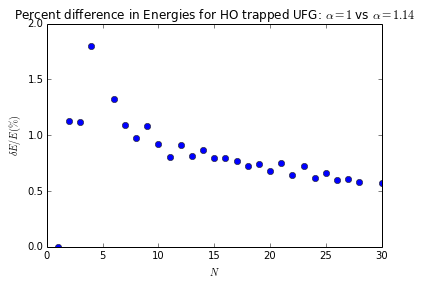

In [62]:
%pylab inline
plt.plot(Nn, 100*(En0-En1)/En0, 'o')
plt.xlabel('$N$')
plt.ylabel(r'$\delta E/E (\%)$')
plt.title(r"Percent difference in Energies for HO trapped UFG: $\alpha=1$ vs $\alpha=1.14$")
plt.savefig("E_alpha.pdf")